# Linear Gaussian filtering and smoothing (continuous-discrete)

Provided is an example of linear state-space models on which one can perform Bayesian filtering and smoothing in order to obtain
a posterior distribution over a latent state trajectory based on noisy observations.
In order to understand the theory behind these methods in detail we refer to [1] and [2].

**References**:
> [1] Särkkä, Simo, and Solin, Arno. Applied Stochastic Differential Equations. Cambridge University Press, 2019.  
>
> [2] Särkkä, Simo. Bayesian Filtering and Smoothing. Cambridge University Press, 2013.

In [1]:
import numpy as np

import probnum as pn
from probnum import filtsmooth, randvars, randprocs
from probnum.problems import TimeSeriesRegressionProblem

In [2]:
rng = np.random.default_rng(seed=123)

In [3]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "svg")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.style.use("../../probnum.mplstyle")

/tmp/ipykernel_125705/236124620.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "svg")


## **Linear Continuous-Discrete** State-Space Model: Ornstein-Uhlenbeck Process

Now, we have a look at **continuous** dynamics. We assume that there is a continuous process that defines the dynamics of our latent space from which we collect discrete linear-Gaussian measurements (as above). Only the dynamics model becomes continuous. In particular, we formulate the dynamics as a stochastic process in terms of a linear time-invariant stochastic differential equation (LTISDE). We refer to [1] for more details.
Consider matrices $\boldsymbol{F} \in \mathbb{R}^{d \times d}$, $\boldsymbol{L} \in \mathbb{R}^{s \times d}$ and $H \in \mathbb{R}^{m \times d}$ where $d$ is the state dimension and $m$ is the dimension of the measurements.
We define the following **continuous-discrete** state-space model:

Let $x(t_0) \sim \mathcal{N}(\mu_0, \Sigma_0)$.

$$
\begin{align}
    d\boldsymbol{x} &= \boldsymbol{F} \, \boldsymbol{x} \, dt + \boldsymbol{L} \, d \boldsymbol{\omega} \\
    \boldsymbol{y}_k &\sim \mathcal{N}(\boldsymbol{H} \, \boldsymbol{x}(t_k), \boldsymbol{R}), \qquad k = 1, \dots, K
\end{align}
$$

where $\boldsymbol{\omega} \in \mathbb{R}^s$ denotes a vector of driving forces (often Brownian Motion).

Note that this can be generalized to a linear time-varying state-space model, as well. Then $\boldsymbol{F}$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{d \times d}$,
$\boldsymbol{L}$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{s \times d}$, and $H$ is a function $\mathbb{T} \rightarrow \mathbb{R}^{m \times d}$ where $\mathbb{T}$ is the "time dimension". In the following example, however, we consider a LTI SDE, namely, the Ornstein-Uhlenbeck Process from which we observe discrete linear Gaussian measurements.

### Define State-Space Model

#### I. Continuous Dynamics Model: Linear, Time-Invariant Stochastic Differential Equation (LTISDE)

In [4]:
state_dim = 1
observation_dim = 1

In [5]:
delta_t = 0.2
# Define Linear, time-invariant Stochastic Differential Equation that models
# the (scalar) Ornstein-Uhlenbeck Process
drift_constant = 0.21
dispersion_constant = np.sqrt(0.5)
drift = -drift_constant * np.eye(state_dim)
force = np.zeros(state_dim)
dispersion = dispersion_constant * np.eye(state_dim)

The _continuous_ counterpart to the discrete LTI Gaussian model is provided via the `LTISDE` class.

In [6]:
# Create dynamics model
dynamics_model = randprocs.markov.continuous.LTISDE(
    drift_matrix=drift,
    force_vector=force,
    dispersion_matrix=dispersion,
)

#### II. Discrete Measurement Model: Linear, Time-Invariant Gaussian Measurements

In [7]:
measurement_marginal_variance = 0.1
measurement_matrix = np.eye(observation_dim, state_dim)
measurement_noise_matrix = measurement_marginal_variance * np.eye(observation_dim)

As above, the measurement model is discrete, LTI Gaussian. Only the dynamics are continuous (i.e. continuous-discrete).

In [8]:
noise = randvars.Normal(mean=np.zeros(observation_dim), cov=measurement_noise_matrix)
measurement_model = randprocs.markov.discrete.LTIGaussian(
    transition_matrix=measurement_matrix,
    noise=noise,
)

#### III. Initial State Random Variable

In [9]:
mu_0 = 10.0 * np.ones(state_dim)
sigma_0 = np.eye(state_dim)
initial_state_rv = randvars.Normal(mean=mu_0, cov=sigma_0)

In [10]:
prior_process = randprocs.markov.MarkovProcess(
    transition=dynamics_model, initrv=initial_state_rv, initarg=0.0
)

### Generate Data for the State-Space Model

Next, sample both latent states and noisy observations from the specified state-space model.

In [11]:
time_grid = np.arange(0.0, 10.0, step=delta_t)

In [12]:
latent_states, observations = randprocs.markov.utils.generate_artificial_measurements(
    rng=rng,
    prior_process=prior_process,
    measmod=measurement_model,
    times=time_grid,
)

In [13]:
regression_problem = TimeSeriesRegressionProblem(
    observations=observations,
    locations=time_grid,
    measurement_models=[measurement_model] * len(time_grid),
)

### Kalman Filtering

In fact, since we still consider a **linear** model, we can apply Kalman Filtering in this case again.
According to Section 10 in [1], the moments of the filtering posterior in the continuous-discrete case are solutions to linear differential equations, which `probnum` solves for us when invoking the `<Kalman_object>.filtsmooth(...)` method.

#### I. Kalman Filter

In [14]:
kalman_filter = filtsmooth.gaussian.Kalman(prior_process)

#### II. Perform Kalman Filtering + Rauch-Tung-Striebel Smoothing

In [15]:
state_posterior, _ = kalman_filter.filtsmooth(regression_problem)

The method `filtsmooth` returns a `KalmanPosterior` object which provides convenience functions for e.g. sampling and prediction.
We can also extract the just computed posterior smoothing state variables by querying the `.state_rvs` property.  
This yields a list of Gaussian Random Variables from which we can extract the statistics in order to visualize them.

In [16]:
grid = np.linspace(0, 11, 500)

posterior_state_rvs = state_posterior(
    grid
)  # List of <num_time_points> Normal Random Variables
posterior_state_means = posterior_state_rvs.mean.squeeze()  # Shape: (num_time_points, )
posterior_state_covs = posterior_state_rvs.cov  # Shape: (num_time_points, )

samples = state_posterior.sample(rng=rng, size=3, t=grid)

### Visualize Results

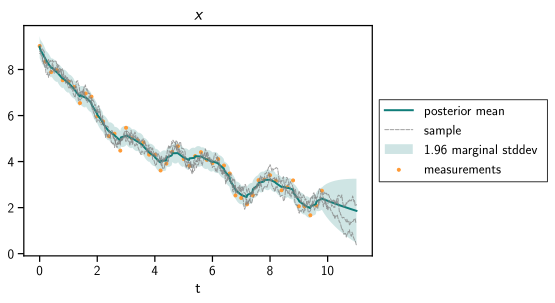

In [17]:
state_fig = plt.figure()

ax = state_fig.add_subplot()

# Plot means
ax.plot(grid, posterior_state_means, label="posterior mean")

# Plot samples
for smp in samples:
    ax.plot(
        grid,
        smp[:, 0],
        color="gray",
        alpha=0.75,
        linewidth=1,
        linestyle="dashed",
        label="sample",
    )


# Plot marginal standard deviations
std_x = np.sqrt(np.abs(posterior_state_covs)).squeeze()
ax.fill_between(
    grid,
    posterior_state_means - 1.96 * std_x,
    posterior_state_means + 1.96 * std_x,
    alpha=0.2,
    label="1.96 marginal stddev",
)
ax.scatter(time_grid, observations, marker=".", label="measurements")
# Add labels etc.
ax.set_xlabel("t")
ax.set_title(r"$x$")

# These two lines just remove duplicate labels (caused by the samples) from the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(
    by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5)
)


state_fig.tight_layout()